# Figure hu_strain

In [1]:
%matplotlib inline
import os.path
import pandas
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd
import pickle
import itertools
import sourmash, sourmash.fig
import time

import numpy as np

import pylab
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
import collections

import altair as alt
from vega import VegaLite

# for the notebook only (not for JupyterLab) run this command once per session
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# Colors & matplotlib style

viridian         = "#4b9179ff" # Green with a hint of blue
selective_yellow = "#ffb500ff" # Excavator yellow
rose             = "#ff1164ff"
hot_pink         = "#ff70b0ff" 
steel_blue       = "#3e80b8ff" 
pumpkin          = "#ff7a24ff"
sycamore         = "#939f49ff"
bone             = "#ded5baff" # Off-white
white_rock       = "#f1ece0ff" # Lighter off-white
fuscous_gray     = "#5c594fff" # Darkish gray
newblack         = "#0e3452ff" # Almost black, blue-tinted

# Style legend box
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = '1'
plt.rcParams["legend.facecolor"] = 'white'

plt.rcParams["axes.facecolor"] = white_rock

# Despine
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False

rcParams.update({'figure.autolayout': True})

# plt.rcParams.keys()

## Figure (a) - neighborhoods in hu are large

In [3]:
# load data & sort by query column

def load_hu(filename):
    x = pandas.read_csv(filename)
    x = x[x['best_containment'] > 0.95].reset_index(drop=True)
    return x

podarV = load_hu('podarV_k31_r1_search_oh0/results.csv')
hu = load_hu('hu-s1_k31_r1_search_oh0/results.csv')

In [4]:
df2 = pd.DataFrame(columns=['group', 'similarity', 'fraction', 'cnt'])
df2.similarity = 1 / podarV.similarity
df2.group = 'Podar V'
df2.fraction = 100 / len(df2)
df2.cnt = np.ones(len(df2))

df3 = pd.DataFrame(columns=['group', 'similarity', 'fraction', 'cnt'])
df3.similarity = 1 / hu.similarity
df3.group = 'Hu'
df3.fraction = 100 / len(df3)
df3.cnt = np.ones(len(df3))

df = pd.concat([df2, df3])

df.similarity = pd.to_numeric(pd.cut(df.similarity,
                                     bins=[0, 1.5, 2, 2.5, 3, 3.5, 4], labels=[1, 1.75, 2.25, 2.75, 3.25, 4]))

gb = df.groupby(['group', 'similarity'])[["fraction"]].sum()

gb = gb.reset_index()

pivot_df = gb.pivot(index='group', columns='similarity', values='fraction')

/Users/t/dev/py36/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


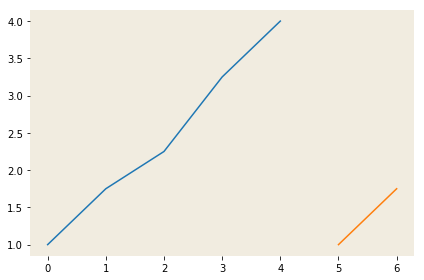

In [5]:
groups = gb.groupby('group')

for name, group in groups:
    group.similarity.plot()
    
plt.show()

/Users/t/dev/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/t/dev/py36/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


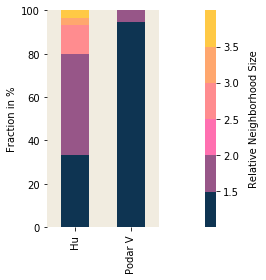

In [6]:
from matplotlib.colors import ListedColormap
plt.rcParams["axes.facecolor"] = white_rock
# fuscous_gray

# cmap = plt.cm.get_cmap('RdBu_r', 6)
# cmap =  ListedColormap(['#3e80b8ff', '#4b9179ff', '#939f49ff', '#ffb500ff', '#ff7a24ff', '#ff1164ff'], "indexed")
# cmap =  ListedColormap(['#3772a5ff', '#4e987eff', '#9eab4fff', '#ffb605ff', '#ff6d0fff', '#ff2370ff'], "indexed")
cmap =  ListedColormap(['#0e3452ff', '#975688ff', '#ff70b0ff', '#ff8c8fff', '#ffa76eff', '#ffc945ff'], "indexed")


# create fake plot to get color bar
plot = plt.scatter(gb.similarity, gb.similarity, c = gb.similarity, cmap = cmap)
plt.clf()
cb = plt.colorbar(plot, ticks=[1.5, 2, 2.5, 3, 3.5], pad=0.25)
cb.outline.set_visible(False)
cb.ax.get_yaxis().labelpad = 10
cb.ax.set_ylabel('Relative Neighborhood Size')

# plt.subplot(121)
pivot_df.plot.bar(ax=plt.gca(), stacked=True, colormap=cmap, legend=False, figsize=(3.8,4))

plt.ylabel('Fraction in %')
plt.ylim(0, 100)

ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
x_axis.set_label_text('')

pyplot.savefig('hu_strain_a.pdf')

plt.tight_layout()
plt.show()

In [7]:
plt.rcParams["axes.facecolor"] = white_rock

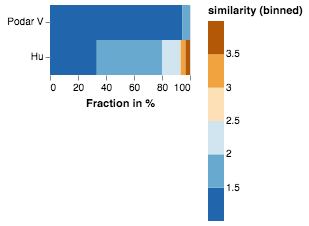

In [8]:
#df1 = pd.DataFrame(columns=['group', 'similarity'])
#df1.similarity = 1 / podar_ref.similarity
#df1.group = 'Podar Ref'

df2 = pd.DataFrame(columns=['group', 'similarity'])
df2.similarity = 1 / podarV.similarity
df2.group = 'Podar V'

df3 = pd.DataFrame(columns=['group', 'similarity'])
df3.similarity = 1 / hu.similarity
df3.group = 'Hu'

df = pd.concat([df2, df3])

VegaLite({
  "mark": {"type": "bar"},
  "width": 140,
  "height": 70,
  "transform": [{
    "window": [{
        "op": "count",
        "as": "count"
    }],
    "frame": [None, None],
    "groupby": ["group"]
  }, {
    "calculate": "100  / datum.count", "as": "fraction"
  }],
  "encoding": {
    "y": {"type": "nominal", "field": "group", "title": None, "sort": ["Podar Ref", "Podar V", "Hu"]},
    "x": {"type": "quantitative", "field": "fraction", "aggregate": "sum", "title": "Fraction in %"},
    # "x": {"type": "quantitative", "field": "count", "aggregate": "sum", "title": "Count"},
    "color": {
      "type": "quantitative",
      "axis": {"title": "Neighborhood Size"},
      "bin": {"maxbins": 8},
      "field": "similarity",
      "scale": {"range": {"scheme": "blueorange"}},
      "legend": {"direction": "horizontal"},
    },
    "order": {"aggregate": "min", "field": "similarity", "type": "quantitative"}
  },
  "config": {
    "scale": {"bandPaddingInner": 0, "bandPaddingOuter": 0},
    "view": {"stroke": 0},
    "text": {"baseline": "middle"},
    "axis": {"tickSize": 5, "tickOpacity": 0, "domainWidth": 0},
    "legend": {"direction": "horizontal"},
  },
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json"
}, df)

## Figure (b) - checkm completeness improvement

In [9]:
# load the completion metrics for the basic bins
bins = {}
bincrumbs = {}

for row in open('files_checkm/checkm-hu.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        if 'cmbnd' in name:
            bincrumbs[genome] = (complete, contam, strain)
        else:
            bins[genome] = (complete, contam, strain)
            
#assert set(bins) == set(bincrumbs)

In [10]:
# load the completion metrics for the plass assemblies
plassbins = {}

for row in open('files_checkm/checkm-plass.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('.')[0].split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        plassbins[genome] = (complete, contam, strain)

In [11]:
# load the completion metrics for the megahit assemblies
megahit = {}

for row in open('files_checkm/checkm-megahit.txt', 'rt'):
    if row.startswith('-'):
        continue
    row = row.split()
    if row[0].startswith('hu'):
        name = row[0]
        genome = 'hu-'+name.split('.')[0].split('-')[1]
        complete, contam, strain = row[-3:]
        complete, contam, strain = float(complete), float(contam), float(strain)
        megahit[genome] = (complete, contam, strain)

In [12]:
summary = []
for k in bins:
    row = [k]
    row.extend(bins[k])
#    row.extend(bincrumbs[k])
    row.extend(plassbins[k])
    row.extend(megahit[k])
    summary.append(row)
    
df = pd.DataFrame(summary, columns=['genome', 'bin_complete', 'bin_contam', 'bin_strain',
#                                    'combined_complete', 'combined_contam', 'combined_strain',
                                    'plass_complete', 'plass_contam', 'plass_strain',
                                    'megahit_complete', 'megahit_contam', 'megahit_strain'])

print(len(df))

23


In [13]:
df['nt_diff'] = df['megahit_complete'] - df['bin_complete']
df['aa_diff'] = df['plass_complete'] - df['megahit_complete']
df['total_diff'] = df['plass_complete'] - df['bin_complete']

/Users/t/dev/py36/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


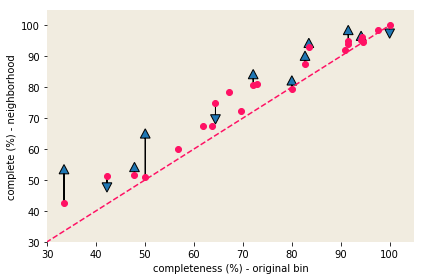

In [14]:
#pyplot.plot(df.bin_complete, df.plass_complete, 'bo')
pyplot.plot(df.bin_complete, df.megahit_complete, 'o', color=rose)

pyplot.plot([0, 100], [0, 100], '--', color=rose)

pyplot.xlabel('completeness (%) - original bin')
pyplot.ylabel('complete (%) - neighborhood')
#pyplot.title('Figure 4b - bins vs nbhd plass assembly')
pyplot.axis(xmin=30, xmax=105, ymin=30, ymax=105)

#pyplot.arrow(50.06, 50.06 + 0.86, 0, 15.62, length_includes_head=True, head_width=2)

for row in df.itertuples():
    if abs(row.aa_diff) > 2.0:
        pyplot.arrow(row.bin_complete, row.megahit_complete, 0, row.aa_diff, length_includes_head=True, head_width=2)
        
#pyplot.savefig('hu_strain_b.pdf')

/Users/t/dev/py36/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


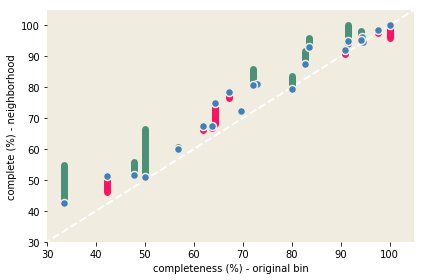

In [15]:
#pyplot.plot(df.bin_complete, df.plass_complete, 'bo')
pyplot.xlabel('completeness (%) - original bin')
pyplot.ylabel('complete (%) - neighborhood')
#pyplot.title('Figure 4b - bins vs nbhd plass assembly')
pyplot.axis(xmin=30, xmax=105, ymin=30, ymax=105)

pyplot.plot([0, 105], [0, 105], '--', lw=2, color='w')    

#pyplot.arrow(50.06, 50.06 + 0.86, 0, 15.62, length_includes_head=True, head_width=2)

for row in df.itertuples():
    x,y = row.bin_complete, row.megahit_complete
    dx,dy = 0, row.aa_diff
    if dy == 0.0:
        continue
    col = viridian if dy > 0 else rose
    pyplot.plot([x,x],[y,y+dy], '-', color=col, lw=7, solid_capstyle='round')
    
pyplot.plot(df.bin_complete, df.megahit_complete, 'o', markersize=8,
            color=steel_blue, markeredgewidth=1.5, 
            markeredgecolor=white_rock)

# viridian
# selective_yellow
# rose
# hot_pink
# steel_blue
# bone
# white_rock
# fuscous_gray
# newblack

pyplot.savefig('hu_strain_b.pdf')